# Visualizzazione del Boundary Layer Height (BLH)


La *Mixing Layer Height* (MLH), o *Planetary Boundary Layer Height* (PBLH), rappresenta lo spessore dello strato atmosferico entro cui avviene il rimescolamento dell’aria con la superficie terrestre.  
È una variabile meteorologica chiave per comprendere la **dispersione** o l’**accumulo** degli inquinanti atmosferici.

- **Valori bassi (100–300 m)** → atmosfera stabile, accumulo di PM₁₀ e NO₂.  
- **Valori alti (1000–2000 m)** → atmosfera instabile, forte rimescolamento e dispersione efficace.  

#### Scopo del notebook

Questo notebook utilizza **un sample di dati ERA5 della variabile BLH** relativi al **periodo 2018–2025**, estratti per la **zona delle stazioni APPA del Trentino**.

Gli obiettivi principali sono:
1. Visualizzare l’**area geografica ERA5** utilizzata per il sample e quella che verrà utilizzata per il dataset completo.  
2. Mostrare l’**associazione tra le stazioni di misura reali** e le **celle della griglia ERA5** più vicine.  
3. Analizzare e confrontare le **serie temporali orarie e giornaliere della BLH** per ciascuna cella.

I dati provengono da file pre-elaborati (`sample_blh_hourly_stations.csv`) che rappresentano un **campione di riferimento**.



**1. Setup iniziale: librerie e credenziali ERA5**

In [ ]:
!pip install cdsapi xarray netCDF4 cftime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.2 MB/s eta 0:00:00


**2. Visualizza area di interesse**

**2.1 AREA SAMPLE TRENTINO**

In [13]:
import folium

# Definizione area (N, W, S, E)
area_sample_trentino = [46.11, 10.94, 45.84, 11.46]

north, west, south, east = area_sample_trentino

# Centro della mappa
center_lat = (north + south) / 2
center_lon = (east + west) / 2

# Mappa
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Rettangolo area
bounds = [(north, west), (south, east)]
folium.Rectangle(
    bounds=bounds,
    color="blue",
    weight=2,
    fill=True,
    fill_opacity=0.2,
    tooltip="Area ERA5 Trentino",
).add_to(m)

# Marker centro
folium.Marker([center_lat, center_lon], tooltip="Centro area").add_to(m)

m

**2.2 AREA NORD ITALIA**

In [16]:
import folium

# Definizione area (N, W, S, E)
area = [47.67, 4.61, 43.54, 16.12]

north, west, south, east = area

# Centro della mappa
center_lat = (north + south) / 2
center_lon = (east + west) / 2

# Mappa
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Rettangolo area
bounds = [(north, west), (south, east)]
folium.Rectangle(
    bounds=bounds,
    color="blue",
    weight=2,
    fill=True,
    fill_opacity=0.2,
    tooltip="Area ERA5 Trentino",
).add_to(m)

# Marker centro
folium.Marker([center_lat, center_lon], tooltip="Centro area").add_to(m)

m

**3. Visualizza dati sample**

Avio A22         -> cell 45.85,10.95  Δ=12.1 km (shared)
Borgo Valsugana  -> cell 46.10,11.45  Δ=5.4 km
Monte Gaza       -> cell 46.10,10.95  Δ=2.0 km
Piana Rotaliana  -> cell 46.10,11.20  Δ=12.7 km (shared)
Riva del Garda   -> cell 45.85,10.95  Δ=9.4 km (shared)
Rovereto LGP     -> cell 45.85,10.95  Δ=8.4 km (shared)
Trento PSC       -> cell 46.10,11.20  Δ=7.0 km (shared)
Trento VBZ       -> cell 46.10,11.20  Δ=6.9 km (shared)


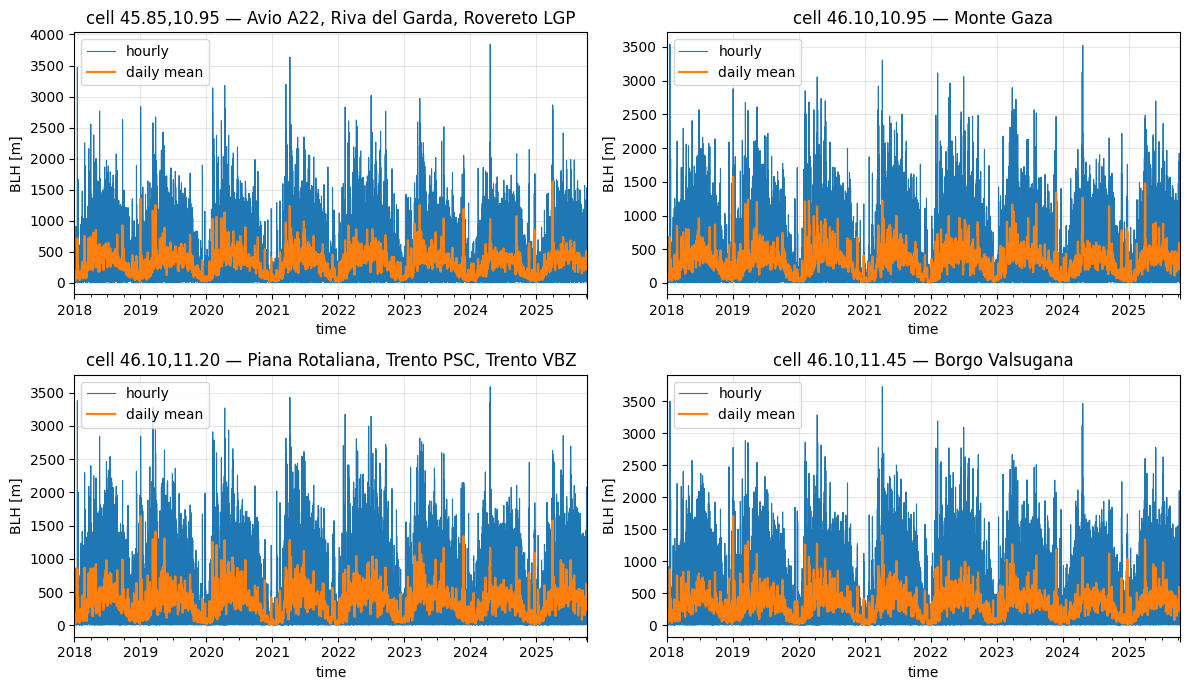

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# --- input ---
csv_in = "../data/data-samples/sample_blh_hourly_stations.csv"  # relative path from notebooks/

# --- load ---
df = pd.read_csv(csv_in)
need = {"station","time","blh_m","grid_lat","grid_lon","dist_km"}
missing = need - set(df.columns)
if missing:
    raise ValueError(f"Mancano colonne: {missing}")

df["time"] = pd.to_datetime(df["time"], utc=True, errors="coerce")
df = df.dropna(subset=["time"])

# cella arrotondata
df["cell_lat"] = df["grid_lat"].round(2)
df["cell_lon"] = df["grid_lon"].round(2)
df["cell"] = list(zip(df["cell_lat"], df["cell_lon"]))

# stampa mappa stazione -> cella (+ shared)
cell_counts = df.groupby("cell")["station"].nunique()
is_shared = set(cell_counts[cell_counts > 1].index)

lines = []
for st, g in df.groupby("station", sort=True):
    r = g.iloc[0]
    cell = (r["cell_lat"], r["cell_lon"])
    tag = " (shared)" if cell in is_shared else ""
    lines.append(f"{st:<16} -> cell {cell[0]:.2f},{cell[1]:.2f}  Δ={float(r['dist_km']):.1f} km{tag}")
print("\n".join(lines))

# serie per cella
# media su stazioni nella stessa cella (se multiple)
val = df[["cell","time","blh_m"]].groupby(["cell","time"], as_index=False).mean()
stations_by_cell = df.groupby("cell")["station"].unique().to_dict()

cells = sorted(val["cell"].unique(), key=lambda c: (c[0], c[1]))
per_fig = 4
n_figs = math.ceil(len(cells) / per_fig)

for i in range(n_figs):
    batch = cells[i*per_fig:(i+1)*per_fig]
    fig, axs = plt.subplots(2, 2, figsize=(12, 7), sharex=False, sharey=False)
    axs = axs.ravel()
    for ax_idx, cell in enumerate(batch):
        ax = axs[ax_idx]
        g = val[val["cell"] == cell].sort_values("time").set_index("time")["blh_m"]
        daily = g.resample("1D").mean()

        g.plot(ax=ax, linewidth=0.8, label="hourly")
        daily.plot(ax=ax, linewidth=1.6, label="daily mean")

        names = ", ".join(sorted(stations_by_cell.get(cell, [])))
        ax.set_title(f"cell {cell[0]:.2f},{cell[1]:.2f} — {names}")
        ax.set_xlabel("time"); ax.set_ylabel("BLH [m]")
        ax.legend()
        ax.grid(True, alpha=0.3)

    # nascondi assi vuoti se <4 celle nell’ultimo batch
    for j in range(len(batch), per_fig):
        fig.delaxes(axs[j])

    fig.tight_layout()
    plt.show()
